In [11]:
import torch
from torch.utils.data import Dataset, DataLoader 
import torch.nn as nn
from torchinfo import summary 
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import os

In [12]:
# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
class PenultimateOutputsDataset(Dataset):
    def __init__(self, folder_path, device='cpu'):
        with open(f'{folder_path}/penultimate_layer_outputs/data.json') as data:
            self.data_tensors = json.load(data)
        self.file_list = [f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{index}.pt' for index in range(self.data_tensors['last_file_indice']+1)]
        self.labels = torch.load(f'{folder_path}/penultimate_layer_labels.pt', map_location=device)
        self.length = self.data_tensors['min_size_segmentation']*self.data_tensors['last_file_indice']+torch.load(f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{self.data_tensors["last_file_indice"]}.pt', map_location=device).shape[0]
        self.device = device
        self.data_cache = None
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        if index < 0 or index >= self.length :
           raise ValueError(f'Index need to be between 0 and {self.length-1}')
        index_file = index//self.data_tensors['min_size_segmentation']
        index_in_file = index%self.data_tensors['min_size_segmentation']
        if (self.data_cache is None) or self.data_cache[0] != index_file :
            file = self.file_list[index_file]
            tensors = torch.load(file, map_location=self.device)
            self.data_cache = (index_file, tensors)
        tensor = self.data_cache[1][index_in_file]
        label = self.labels[index]
        return tensor, label


In [14]:
outputs_folder = "../data/saved_outputs/train"
folder_model = "parameter_to_zeros" #"same_parameter_real_optimized_function"
models_folder = f"../data/saved_models/{folder_model}"

if not os.path.exists(models_folder):
    os.makedirs(models_folder)
    
input_size = 2048
num_classes = 1000

batch_size = 256
num_epochs = 90

weight_decay_parameter = 1e-4
learning_rate = 0.1
momentum = 0.9
lr_decay_step = 30
decay_rate = 0.1


In [15]:
dataset = PenultimateOutputsDataset(outputs_folder)
train_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)

In [16]:
len(dataset)

1281167

In [17]:
class LogisticRegression(nn.Module): 
    def __init__(self, input_size, num_classes): 
        super(LogisticRegression, self).__init__() 
        self.linear = nn.Linear(input_size, num_classes) 

        # Initialiser les poids à zéro
        self.linear.weight.data.zero_()
        if self.linear.bias is not None:
            self.linear.bias.data.zero_()
  
    def forward(self, x): 
        out = self.linear(x) 
        return out 

In [18]:
# On définit le model
model = LogisticRegression(input_size=input_size, num_classes=num_classes) 
model = model.to(DEVICE)
summary(model, input_size=(batch_size, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
LogisticRegression                       [256, 1000]               --
├─Linear: 1-1                            [256, 1000]               2,049,000
Total params: 2,049,000
Trainable params: 2,049,000
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 524.54
Input size (MB): 2.10
Forward/backward pass size (MB): 2.05
Params size (MB): 8.20
Estimated Total Size (MB): 12.34

In [19]:
# Define the loss function and optimizer 
loss_function = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay_parameter)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=decay_rate)

In [20]:
# Train the model
correct_predictions=0
loss_history = []
true_loss_v1_history = []
true_loss_v2_history = []
accuracy_history = []
# curve process (temporary)
moyenne_erreur_classe_model = []
loss_epoch = []
weights_epoch = []
nb_image_classe = torch.bincount(dataset.labels).to(DEVICE)
#end
for epoch in range(num_epochs): 
    # curve process (temporary)
    erreur_total_classe = torch.zeros(1000, device=DEVICE)
    #end
    for inputs, labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
        
        # Move inputs and labels to the device 
        inputs = inputs.to(DEVICE) 
        labels = labels.to(DEVICE)
        
        # Forward pass 
        outputs = model(inputs) 
        loss = loss_function(outputs, labels)
        true_loss_v1 = loss.item() + weight_decay_parameter * sum(t.pow(2).sum().item() for t in model.state_dict().values()) / 2
        true_loss_v2 = loss.item() + weight_decay_parameter * model.state_dict()['linear.weight'].pow(2).sum().item() / 2


        # curve process (temporary)
        erreur = nn.functional.cross_entropy(outputs,labels,reduction='none') + weight_decay_parameter * sum(t.pow(2).sum() for t in model.state_dict().values()) / 2
        vrai_loss = torch.mean(erreur).item() #recupère la loss du batch
        #end
        
        _, predicted = torch.max(outputs, 1)

        # Ajout des prédictions correctes au total
        correct_predictions += (predicted == labels).sum().item()
        
        # Backward and optimize 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()

    # curve process (temporary)
    print(f"Global minimized function value : {vrai_loss}") 
    loss_epoch.append(vrai_loss)
    moyenne_erreur_classe_model.append((erreur_total_classe/nb_image_classe).tolist())
    weights_epoch.append(sum(t.abs().sum() for t in model.state_dict().values()))
    #end
    
    # update lr
    scheduler.step()

    # save intermediate models
    torch.save(model.state_dict(), f'{models_folder}/epoch-{epoch}.pt')

    # process accuracy
    accuracy = 100 * correct_predictions / len(dataset)
    correct_predictions=0
    
    print(f'>> Accuracy: {accuracy} %\n-- Loss: {loss.item()}\n-- True loss 1: {true_loss_v1}\n-- True loss 2: {true_loss_v2}')

    # save accuracy and loss
    loss_history.append(loss.item())
    accuracy_history.append(accuracy)
    true_loss_v1_history.append(true_loss_v1)
    true_loss_v2_history.append(true_loss_v2)    

Epoch [1/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.10it/s]


Global minimized function value : 46.756195068359375
>> Accuracy: 9.110834106716768 %
-- Loss: 30.32522964477539
-- True loss 1: 46.75619443359375
-- True loss 2: 46.68159526977539


Epoch [2/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 117.61it/s]


Global minimized function value : 21.274765014648438
>> Accuracy: 55.72903454428658 %
-- Loss: 10.079760551452637
-- True loss 1: 21.27476812591553
-- True loss 2: 21.23444180145264


Epoch [3/90]: 100%|████████████████████████████████████████████████████████████████| 5005/5005 [00:52<00:00, 95.26it/s]


Global minimized function value : 15.79551887512207
>> Accuracy: 60.99407805539793 %
-- Loss: 7.379249572753906
-- True loss 1: 15.795521649169922
-- True loss 2: 15.762987854003907


Epoch [4/90]: 100%|████████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 99.03it/s]


Global minimized function value : 14.691579818725586
>> Accuracy: 58.75822589873139 %
-- Loss: 6.885639667510986
-- True loss 1: 14.69158108291626
-- True loss 2: 14.660353730010986


Epoch [5/90]: 100%|████████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 98.97it/s]


Global minimized function value : 14.8876953125
>> Accuracy: 55.51891361547714 %
-- Loss: 6.783611297607422
-- True loss 1: 14.887693936157227
-- True loss 2: 14.854854266357423


Epoch [6/90]: 100%|████████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 96.68it/s]


Global minimized function value : 14.944653511047363
>> Accuracy: 55.04309742601862 %
-- Loss: 6.732390880584717
-- True loss 1: 14.944653136444092
-- True loss 2: 14.911802599334717


Epoch [7/90]: 100%|████████████████████████████████████████████████████████████████| 5005/5005 [00:52<00:00, 95.13it/s]


Global minimized function value : 14.89122200012207
>> Accuracy: 55.39839849137544 %
-- Loss: 6.703956127166748
-- True loss 1: 14.891222631073
-- True loss 2: 14.857931127166749


Epoch [8/90]: 100%|████████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 97.90it/s]


Global minimized function value : 14.790369987487793
>> Accuracy: 56.33106378793709 %
-- Loss: 6.7597832679748535
-- True loss 1: 14.790371381378174
-- True loss 2: 14.757768424224853


Epoch [9/90]: 100%|████████████████████████████████████████████████████████████████| 5005/5005 [00:52<00:00, 95.85it/s]


Global minimized function value : 14.937843322753906
>> Accuracy: 55.58510326912885 %
-- Loss: 6.797436714172363
-- True loss 1: 14.937844111633302
-- True loss 2: 14.904632026672363


Epoch [10/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 99.06it/s]


Global minimized function value : 14.907173156738281
>> Accuracy: 55.80490287370811 %
-- Loss: 6.778021335601807
-- True loss 1: 14.907173752593994
-- True loss 2: 14.874191648101807


Epoch [11/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 97.86it/s]


Global minimized function value : 15.060121536254883
>> Accuracy: 55.25282808564379 %
-- Loss: 6.810406684875488
-- True loss 1: 15.06012258758545
-- True loss 2: 15.026312934875488


Epoch [12/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:52<00:00, 94.71it/s]


Global minimized function value : 14.908110618591309
>> Accuracy: 55.48441381958792 %
-- Loss: 6.6958770751953125
-- True loss 1: 14.908111141967774
-- True loss 2: 14.874766137695312


Epoch [13/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:53<00:00, 94.37it/s]


Global minimized function value : 14.840256690979004
>> Accuracy: 55.72013640688529 %
-- Loss: 6.690634250640869
-- True loss 1: 14.840257343292237
-- True loss 2: 14.80679362564087


Epoch [14/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:52<00:00, 96.21it/s]


Global minimized function value : 14.902685165405273
>> Accuracy: 55.90309460046973 %
-- Loss: 6.7877326011657715
-- True loss 1: 14.902685344696046
-- True loss 2: 14.869790413665772


Epoch [15/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 97.23it/s]


Global minimized function value : 14.805098533630371
>> Accuracy: 55.69391031770253 %
-- Loss: 6.68009090423584
-- True loss 1: 14.805099320983887
-- True loss 2: 14.77185340423584


Epoch [16/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 98.80it/s]


Global minimized function value : 14.867118835449219
>> Accuracy: 55.62186662628682 %
-- Loss: 6.720383644104004
-- True loss 1: 14.86712109222412
-- True loss 2: 14.834025831604004


Epoch [17/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 101.15it/s]


Global minimized function value : 14.85657787322998
>> Accuracy: 55.685090234138094 %
-- Loss: 6.710137367248535
-- True loss 1: 14.856577711486818
-- True loss 2: 14.823182679748536


Epoch [18/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 98.48it/s]


Global minimized function value : 14.92441177368164
>> Accuracy: 55.55356951904006 %
-- Loss: 6.760868549346924
-- True loss 1: 14.924411737823487
-- True loss 2: 14.891266205596924


Epoch [19/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:53<00:00, 93.86it/s]


Global minimized function value : 14.832260131835938
>> Accuracy: 55.7704030778189 %
-- Loss: 6.711967468261719
-- True loss 1: 14.832257989501954
-- True loss 2: 14.798909655761719


Epoch [20/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:56<00:00, 89.18it/s]


Global minimized function value : 14.883580207824707
>> Accuracy: 55.691880917944346 %
-- Loss: 6.738313674926758
-- True loss 1: 14.883579776000976
-- True loss 2: 14.850426174926758


Epoch [21/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:52<00:00, 95.08it/s]


Global minimized function value : 15.019060134887695
>> Accuracy: 55.48706765004094 %
-- Loss: 6.799432277679443
-- True loss 1: 15.019058712005616
-- True loss 2: 14.985358058929444


Epoch [22/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:54<00:00, 92.21it/s]


Global minimized function value : 14.988868713378906
>> Accuracy: 55.6658109364353 %
-- Loss: 6.794710159301758
-- True loss 1: 14.988869692993164
-- True loss 2: 14.955432034301758


Epoch [23/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 97.38it/s]


Global minimized function value : 14.816620826721191
>> Accuracy: 55.72887843661287 %
-- Loss: 6.688862323760986
-- True loss 1: 14.816620697784424
-- True loss 2: 14.783101386260986


Epoch [24/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 98.25it/s]


Global minimized function value : 14.831324577331543
>> Accuracy: 55.713970153773865 %
-- Loss: 6.692372798919678
-- True loss 1: 14.83132785873413
-- True loss 2: 14.798191548919679


Epoch [25/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 97.81it/s]


Global minimized function value : 14.875849723815918
>> Accuracy: 55.596811344656864 %
-- Loss: 6.725928783416748
-- True loss 1: 14.875850762176514
-- True loss 2: 14.842416283416748


Epoch [26/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:54<00:00, 91.26it/s]


Global minimized function value : 14.909929275512695
>> Accuracy: 55.75986580984368 %
-- Loss: 6.765343189239502
-- True loss 1: 14.90992940750122
-- True loss 2: 14.876865064239503


Epoch [27/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:58<00:00, 85.79it/s]


Global minimized function value : 14.888726234436035
>> Accuracy: 55.58627407668165 %
-- Loss: 6.751613616943359
-- True loss 1: 14.888727825927734
-- True loss 2: 14.85534799194336


Epoch [28/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 100.96it/s]


Global minimized function value : 14.913362503051758
>> Accuracy: 55.68711963389628 %
-- Loss: 6.741464614868164
-- True loss 1: 14.913361141967775
-- True loss 2: 14.880041177368165


Epoch [29/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:57<00:00, 86.77it/s]


Global minimized function value : 14.80848217010498
>> Accuracy: 55.74238175038851 %
-- Loss: 6.677120685577393
-- True loss 1: 14.808483435821534
-- True loss 2: 14.774973029327393


Epoch [30/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 98.97it/s]


Global minimized function value : 14.877249717712402
>> Accuracy: 55.64902936151181 %
-- Loss: 6.725758075714111
-- True loss 1: 14.877249988555908
-- True loss 2: 14.844151825714112


Epoch [31/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 96.95it/s]


Global minimized function value : 8.712686538696289
>> Accuracy: 69.05532221794661 %
-- Loss: 1.6424970626831055
-- True loss 1: 8.712686917114258
-- True loss 2: 8.688287687683106


Epoch [32/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:52<00:00, 95.02it/s]


Global minimized function value : 8.168062210083008
>> Accuracy: 80.7159410131544 %
-- Loss: 1.9237422943115234
-- True loss 1: 8.168063366699219
-- True loss 2: 8.148075888061523


Epoch [33/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:54<00:00, 92.38it/s]


Global minimized function value : 7.393072128295898
>> Accuracy: 83.1895451568765 %
-- Loss: 1.8488237857818604
-- True loss 1: 7.393071754837036
-- True loss 2: 7.375974567031861


Epoch [34/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:52<00:00, 95.83it/s]


Global minimized function value : 6.642309665679932
>> Accuracy: 84.40016016647323 %
-- Loss: 1.7084836959838867
-- True loss 1: 6.64231011505127
-- True loss 2: 6.627351664733887


Epoch [35/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:56<00:00, 89.33it/s]


Global minimized function value : 5.9788055419921875
>> Accuracy: 84.98946663471663 %
-- Loss: 1.5834742784500122
-- True loss 1: 5.978805269050598
-- True loss 2: 5.965539512825012


Epoch [36/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 100.79it/s]


Global minimized function value : 5.394581317901611
>> Accuracy: 85.4004981395868 %
-- Loss: 1.4765454530715942
-- True loss 1: 5.394581413459778
-- True loss 2: 5.382753265571594


Epoch [37/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:47<00:00, 104.78it/s]


Global minimized function value : 4.876588344573975
>> Accuracy: 85.58946647860895 %
-- Loss: 1.3827720880508423
-- True loss 1: 4.876588812446594
-- True loss 2: 4.865995134925843


Epoch [38/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 97.10it/s]


Global minimized function value : 4.418050765991211
>> Accuracy: 85.77219051068283 %
-- Loss: 1.3012391328811646
-- True loss 1: 4.418050947761536
-- True loss 2: 4.408568429756165


Epoch [39/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 98.93it/s]


Global minimized function value : 4.012923240661621
>> Accuracy: 85.8404876179296 %
-- Loss: 1.2317930459976196
-- True loss 1: 4.012923238563538
-- True loss 2: 4.00440984287262


Epoch [40/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:52<00:00, 96.11it/s]


Global minimized function value : 3.654170513153076
>> Accuracy: 85.93407416831685 %
-- Loss: 1.1714671850204468
-- True loss 1: 3.654170680046082
-- True loss 2: 3.646539841270447


Epoch [41/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:53<00:00, 94.16it/s]


Global minimized function value : 3.3362104892730713
>> Accuracy: 85.91393627840867 %
-- Loss: 1.119258165359497
-- True loss 1: 3.3362106464385985
-- True loss 2: 3.3293509387969973


Epoch [42/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 97.69it/s]


Global minimized function value : 3.051023006439209
>> Accuracy: 85.94031847526513 %
-- Loss: 1.0701013803482056
-- True loss 1: 3.0510229814529417
-- True loss 2: 3.0448677865982057


Epoch [43/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:53<00:00, 93.17it/s]


Global minimized function value : 2.7965505123138428
>> Accuracy: 85.8783437288035 %
-- Loss: 1.0256953239440918
-- True loss 1: 2.7965505546569824
-- True loss 2: 2.791013683319092


Epoch [44/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:47<00:00, 104.65it/s]


Global minimized function value : 2.569042444229126
>> Accuracy: 85.83650687225007 %
-- Loss: 0.984381377696991
-- True loss 1: 2.569042541408539
-- True loss 2: 2.564071612071991


Epoch [45/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 99.33it/s]


Global minimized function value : 2.367623805999756
>> Accuracy: 85.7100596565475 %
-- Loss: 0.9482829570770264
-- True loss 1: 2.3676239742279055
-- True loss 2: 2.3631513164520266


Epoch [46/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 98.48it/s]


Global minimized function value : 2.1907355785369873
>> Accuracy: 85.60390643842685 %
-- Loss: 0.9173226356506348
-- True loss 1: 2.190735717391968
-- True loss 2: 2.186718436431885


Epoch [47/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:53<00:00, 93.67it/s]


Global minimized function value : 2.036914110183716
>> Accuracy: 85.42485093668508 %
-- Loss: 0.8926220536231995
-- True loss 1: 2.0369142090797423
-- True loss 2: 2.0333007645606997


Epoch [48/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:52<00:00, 94.62it/s]


Global minimized function value : 1.9055107831954956
>> Accuracy: 85.26320144056162 %
-- Loss: 0.8745298981666565
-- True loss 1: 1.9055107399940492
-- True loss 2: 1.9022652497291566


Epoch [49/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:53<00:00, 93.26it/s]


Global minimized function value : 1.7952923774719238
>> Accuracy: 85.02131260015283 %
-- Loss: 0.8638624548912048
-- True loss 1: 1.7952923373222351
-- True loss 2: 1.7923735877037048


Epoch [50/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:53<00:00, 93.07it/s]


Global minimized function value : 1.7055494785308838
>> Accuracy: 84.79160015829318 %
-- Loss: 0.8606495261192322
-- True loss 1: 1.7055494997978211
-- True loss 2: 1.7029258933067322


Epoch [51/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:47<00:00, 106.12it/s]


Global minimized function value : 1.633988618850708
>> Accuracy: 84.48477052562234 %
-- Loss: 0.8645785450935364
-- True loss 1: 1.6339885087013246
-- True loss 2: 1.6316304005622864


Epoch [52/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 100.48it/s]


Global minimized function value : 1.5781724452972412
>> Accuracy: 84.20900632001917 %
-- Loss: 0.8737118244171143
-- True loss 1: 1.5781724964141846
-- True loss 2: 1.5760531330108642


Epoch [53/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:52<00:00, 94.57it/s]


Global minimized function value : 1.5347105264663696
>> Accuracy: 83.85417357768347 %
-- Loss: 0.8861538767814636
-- True loss 1: 1.5347106360435485
-- True loss 2: 1.5328045115470887


Epoch [54/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:00<00:00, 82.41it/s]


Global minimized function value : 1.5009135007858276
>> Accuracy: 83.5418801764329 %
-- Loss: 0.8997034430503845
-- True loss 1: 1.5009135270118714
-- True loss 2: 1.4991966071128846


Epoch [55/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:00<00:00, 83.25it/s]


Global minimized function value : 1.4736295938491821
>> Accuracy: 83.19563335615108 %
-- Loss: 0.9128440618515015
-- True loss 1: 1.4736295583724974
-- True loss 2: 1.4720842962265015


Epoch [56/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:06<00:00, 75.82it/s]


Global minimized function value : 1.4508154392242432
>> Accuracy: 82.91838612764768 %
-- Loss: 0.9237921833992004
-- True loss 1: 1.4508154815673828
-- True loss 2: 1.4494206013679505


Epoch [57/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:07<00:00, 73.77it/s]


Global minimized function value : 1.4305720329284668
>> Accuracy: 82.5559821631372 %
-- Loss: 0.9317979216575623
-- True loss 1: 1.4305720688819885
-- True loss 2: 1.4293090544700622


Epoch [58/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:13<00:00, 68.04it/s]


Global minimized function value : 1.4123740196228027
>> Accuracy: 82.28615004913489 %
-- Loss: 0.9367032647132874
-- True loss 1: 1.4123738978385925
-- True loss 2: 1.4112238701820374


Epoch [59/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:18<00:00, 63.75it/s]


Global minimized function value : 1.395433783531189
>> Accuracy: 81.99087238431837 %
-- Loss: 0.9391321539878845
-- True loss 1: 1.3954337731361388
-- True loss 2: 1.3943859625816346


Epoch [60/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:11<00:00, 69.85it/s]


Global minimized function value : 1.3804527521133423
>> Accuracy: 81.77801957121905 %
-- Loss: 0.9398515820503235
-- True loss 1: 1.3804527424812316
-- True loss 2: 1.3794914258003235


Epoch [61/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:58<00:00, 86.25it/s]


Global minimized function value : 0.9246588945388794
>> Accuracy: 85.93532302970651 %
-- Loss: 0.48932701349258423
-- True loss 1: 0.9246590382575989
-- True loss 2: 0.9236852166175842


Epoch [62/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:55<00:00, 89.95it/s]


Global minimized function value : 0.8978325724601746
>> Accuracy: 88.31760418431008 %
-- Loss: 0.4670480191707611
-- True loss 1: 0.8978327001094819
-- True loss 2: 0.8968536832332612


Epoch [63/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:54<00:00, 92.01it/s]


Global minimized function value : 0.8816787004470825
>> Accuracy: 89.4043477548204 %
-- Loss: 0.45511478185653687
-- True loss 1: 0.8816788178443908
-- True loss 2: 0.8807007193565368


Epoch [64/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:54<00:00, 92.00it/s]


Global minimized function value : 0.8690319657325745
>> Accuracy: 89.9204397240953 %
-- Loss: 0.44650185108184814
-- True loss 1: 0.8690320970535279
-- True loss 2: 0.8680589799880982


Epoch [65/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:48<00:00, 103.96it/s]


Global minimized function value : 0.8582603335380554
>> Accuracy: 90.19807722178295 %
-- Loss: 0.439632385969162
-- True loss 1: 0.8582603412151337
-- True loss 2: 0.857294739484787


Epoch [66/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 97.78it/s]


Global minimized function value : 0.8487163782119751
>> Accuracy: 90.3550434876952 %
-- Loss: 0.43388429284095764
-- True loss 1: 0.8487163025379181
-- True loss 2: 0.8477597811222077


Epoch [67/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 97.90it/s]


Global minimized function value : 0.8400605916976929
>> Accuracy: 90.45690374478893 %
-- Loss: 0.4289306700229645
-- True loss 1: 0.8400606112003326
-- True loss 2: 0.8391141661167145


Epoch [68/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 99.10it/s]


Global minimized function value : 0.8321464657783508
>> Accuracy: 90.52832300550982 %
-- Loss: 0.4246324598789215
-- True loss 1: 0.8321464537143708
-- True loss 2: 0.8312107313632966


Epoch [69/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 96.63it/s]


Global minimized function value : 0.824882984161377
>> Accuracy: 90.57991659166994 %
-- Loss: 0.42090365290641785
-- True loss 1: 0.8248829468250275
-- True loss 2: 0.8239583648204803


Epoch [70/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 99.15it/s]


Global minimized function value : 0.8182040452957153
>> Accuracy: 90.62175344822337 %
-- Loss: 0.41768205165863037
-- True loss 1: 0.8182040256500245
-- True loss 2: 0.8172908407211303


Epoch [71/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 96.56it/s]


Global minimized function value : 0.8120409846305847
>> Accuracy: 90.6540677366807 %
-- Loss: 0.41490238904953003
-- True loss 1: 0.8120410701751709
-- True loss 2: 0.8111394251823425


Epoch [72/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:47<00:00, 104.98it/s]


Global minimized function value : 0.8063308596611023
>> Accuracy: 90.67982550284233 %
-- Loss: 0.4125041961669922
-- True loss 1: 0.8063309144973755
-- True loss 2: 0.8054408660888672


Epoch [73/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 96.32it/s]


Global minimized function value : 0.8010417222976685
>> Accuracy: 90.70511494598284 %
-- Loss: 0.4104580879211426
-- True loss 1: 0.8010417713165283
-- True loss 2: 0.8001633125305176


Epoch [74/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 100.50it/s]


Global minimized function value : 0.796128511428833
>> Accuracy: 90.72431618984879 %
-- Loss: 0.4087211787700653
-- True loss 1: 0.796128557252884
-- True loss 2: 0.7952616328716278


Epoch [75/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 97.76it/s]


Global minimized function value : 0.7915542721748352
>> Accuracy: 90.73977084954576 %
-- Loss: 0.40725862979888916
-- True loss 1: 0.7915543436050415
-- True loss 2: 0.7906988641738892


Epoch [76/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 97.67it/s]


Global minimized function value : 0.787272036075592
>> Accuracy: 90.75436691703736 %
-- Loss: 0.40602511167526245
-- True loss 1: 0.7872721869468688
-- True loss 2: 0.7864280413627625


Epoch [77/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:52<00:00, 95.29it/s]


Global minimized function value : 0.7832446694374084
>> Accuracy: 90.76826049999727 %
-- Loss: 0.40498456358909607
-- True loss 1: 0.7832446490764617
-- True loss 2: 0.7824117120265961


Epoch [78/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:00<00:00, 82.70it/s]


Global minimized function value : 0.7794522047042847
>> Accuracy: 90.78793006688433 %
-- Loss: 0.40411898493766785
-- True loss 1: 0.7794522727489472
-- True loss 2: 0.7786304107189179


Epoch [79/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:57<00:00, 86.47it/s]


Global minimized function value : 0.7758602499961853
>> Accuracy: 90.79971619624921 %
-- Loss: 0.403394877910614
-- True loss 1: 0.7758602466583252
-- True loss 2: 0.775049321269989


Epoch [80/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:01<00:00, 80.77it/s]


Global minimized function value : 0.7724524140357971
>> Accuracy: 90.81064373340868 %
-- Loss: 0.40279749035835266
-- True loss 1: 0.7724524285793304
-- True loss 2: 0.7716522999286652


Epoch [81/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:59<00:00, 83.42it/s]


Global minimized function value : 0.7692117094993591
>> Accuracy: 90.82211764742614 %
-- Loss: 0.4023107588291168
-- True loss 1: 0.769211755657196
-- True loss 2: 0.7684222822666169


Epoch [82/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:59<00:00, 84.81it/s]


Global minimized function value : 0.7661195397377014
>> Accuracy: 90.82883027739553 %
-- Loss: 0.4019172191619873
-- True loss 1: 0.7661195913791656
-- True loss 2: 0.7653406322479248


Epoch [83/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:00<00:00, 82.28it/s]


Global minimized function value : 0.7631589770317078
>> Accuracy: 90.83694787642828 %
-- Loss: 0.40160131454467773
-- True loss 1: 0.763159109210968
-- True loss 2: 0.7623905235290527


Epoch [84/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:01<00:00, 81.88it/s]


Global minimized function value : 0.7603158950805664
>> Accuracy: 90.84327023721342 %
-- Loss: 0.40134990215301514
-- True loss 1: 0.7603158714771271
-- True loss 2: 0.7595575193405151


Epoch [85/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:54<00:00, 92.11it/s]


Global minimized function value : 0.7575703263282776
>> Accuracy: 90.85271475147267 %
-- Loss: 0.4011442959308624
-- True loss 1: 0.7575703605651856
-- True loss 2: 0.75682210354805


Epoch [86/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:06<00:00, 75.74it/s]


Global minimized function value : 0.7549126744270325
>> Accuracy: 90.8602079198106 %
-- Loss: 0.40097588300704956
-- True loss 1: 0.754912716960907
-- True loss 2: 0.7541744181632996


Epoch [87/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:03<00:00, 78.83it/s]


Global minimized function value : 0.7523421049118042
>> Accuracy: 90.8666083344326 %
-- Loss: 0.40084540843963623
-- True loss 1: 0.7523421957015992
-- True loss 2: 0.7516137189865113


Epoch [88/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:00<00:00, 82.84it/s]


Global minimized function value : 0.7498524188995361
>> Accuracy: 90.8711354569701 %
-- Loss: 0.4007470905780792
-- True loss 1: 0.7498523799419403
-- True loss 2: 0.7491335896015168


Epoch [89/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:56<00:00, 88.11it/s]


Global minimized function value : 0.7474449872970581
>> Accuracy: 90.87777003310264 %
-- Loss: 0.40068361163139343
-- True loss 1: 0.7474449745178222
-- True loss 2: 0.746735735654831


Epoch [90/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:57<00:00, 86.98it/s]

Global minimized function value : 0.7451143264770508
>> Accuracy: 90.87987748669768 %
-- Loss: 0.4006505310535431
-- True loss 1: 0.7451143659114838
-- True loss 2: 0.7444145447254181


In [21]:
torch.save(accuracy_history, f'{models_folder}/accuracy.pt')
torch.save(loss_history, f'{models_folder}/loss.pt')
torch.save(true_loss_v1_history, f'{models_folder}/true_loss_v1.pt')
torch.save(true_loss_v2_history, f'{models_folder}/true_loss_v2.pt')

In [22]:
# acc = torch.load('../data/saved_models/constant_step_lr/accuracy.pt')
# loss = torch.load('../data/saved_models/constant_step_lr/loss.pt')
# params20 = torch.load('../data/saved_models/constant_step_lr/epoch-20.pt')
# params40 = torch.load('../data/saved_models/constant_step_lr/epoch-40.pt')

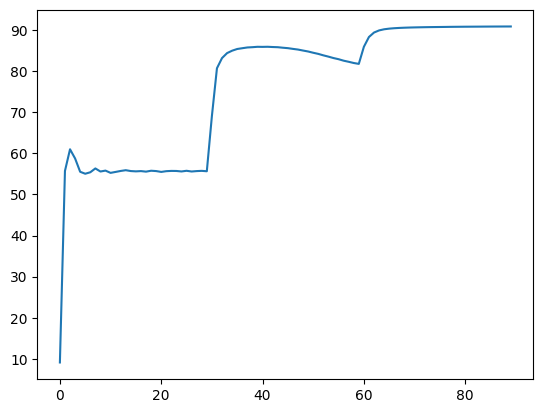

In [23]:
plt.plot(accuracy_history)

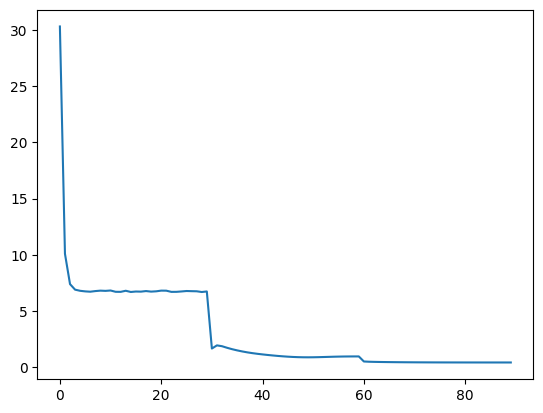

In [24]:
plt.plot(loss_history)

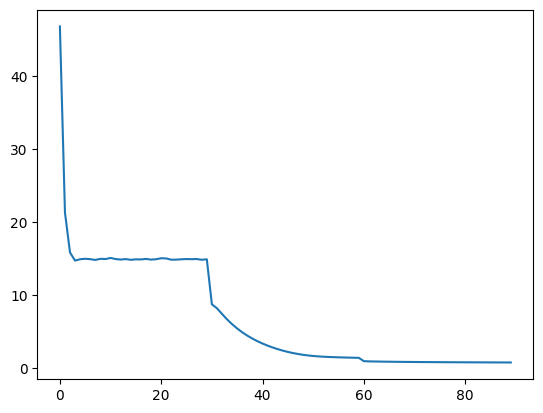

In [25]:
plt.plot(true_loss_v1_history)

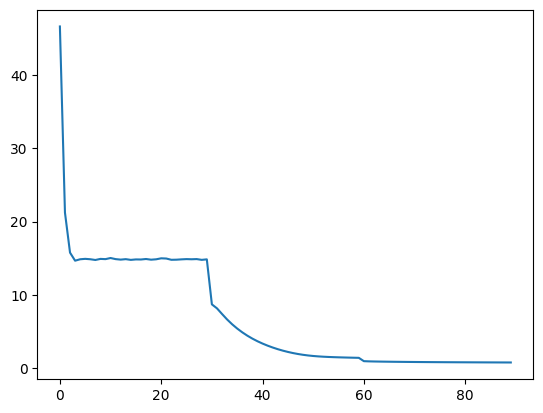

In [26]:
plt.plot(true_loss_v2_history)

In [27]:
tv1 = loss.item() + weight_decay_parameter * sum(t.pow(2).sum().item() for t in model.state_dict().values()) / 2
tv1

0.7451138046264649

In [28]:
err = torch.nn.functional.cross_entropy(outputs,labels,reduction='none') + weight_decay_parameter * sum(t.pow(2).sum().item() for t in model.state_dict().values()) / 2
vrai_loss = torch.mean(err).item() #recupère la loss du batch
vrai_loss

0.7451138496398926